![logo](https://github.com/HelmholtzAI-Consultants-Munich/XAI-Tutorials/blob/main/docs/source/_figures/Helmholtz-AI.png?raw=true)

# Model-Agnostic Interpretation with SHAP

In this Notebook, we will demonstrate how to use the SHapley Additive exPlanations (SHAP) method and interpret its results.

--------

## Getting Started

### Setup Colab environment

If you installed the packages and requirements on your machine, you can skip this section and start from the import section.
Otherwise, you can follow and execute the tutorial on your browser. To start working on the notebook, click on the following button. This will open this page in the Colab environment, and you will be able to execute the code on your own.

<a href="https://colab.research.google.com/github/HelmholtzAI-Consultants-Munich/XAI-Tutorials/blob/HelmholtzSummerSchool-2024/xai-for-random-forest/3-Tutorial_SHAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Now that you opened the notebook in Google Colab, follow the next step:

1. Run this cell to connect your Google Drive to Colab and install packages
2. Allow this notebook to access your Google Drive files. Click on 'Yes', and select your account.
3. "Google Drive for desktop wants to access your Google Account". Click on 'Allow'.
   
At this point, a folder has been created in your Drive, and you can navigate it through the lefthand panel in Colab. You might also have received an email that informs you about the access on your Google Drive.

In [1]:
# Mount drive folder to dbe abale to download repo
from google.colab import drive
drive.mount('/content/drive')

# Switch to correct folder'
%cd /content/drive/MyDrive

# Don't run this cell if you already cloned the repo 
%rm -r XAI-Tutorials
!git clone --branch HelmholtzSummerSchool-2024 https://github.com/HelmholtzAI-Consultants-Munich/XAI-Tutorials.git
%cd XAI-Tutorials/xai-for-random-forest/

# Install additional packages
%pip install shap

### Imports

Let's start with importing all required Python packages.

In [1]:
import pickle

import numpy as np
import pandas as pd

import shap

Now, we fix the random seeds to ensure reproducible results, as we work with (pseudo) random numbers.

In [2]:
# assert reproducible random number generation
seed = 1
np.random.seed(seed)

--------

## Data and Model Loading: The California Housing Dataset

In this notebook, we will work with the **California Housing dataset**, containing 20,640 median house values for California districts (expressed in $100,000), which are described by 8 numeric feature. Each row in the dataset represents a block of houses, not a single household. The data pertains to the house prices found in a given California district and some summary statistics about them based on the 1990 census data. Our goal is to **predict price** of house blocks and find the most predictive features.

<center><img src="https://github.com/HelmholtzAI-Consultants-Munich/XAI-Tutorials/blob/main/docs/source/_figures/dataset_california_housing.jpg?raw=true" width="900" /></center>

<font size=1> Source: [Link](https://www.kaggle.com/datasets/harrywang/housing)

In the notebook [*0-Tutorial_RandomForest_Model_Housing_Wine_Penguins.ipynb*](./0-Tutorial_RandomForest_Model_Housing_Wine_Penguins.ipynb), we explain how to do the exploratory data analysis, preprocess the data and train a Random Forest model with the given data. The focus of this notebook is the interpretation of the previously trained model.

In [3]:
# Load and unpack the data
with open('../models/model_rf_housing.pickle', 'rb') as handle:
    data_and_model = pickle.load(handle)

X_train = data_and_model[0]
X_test = data_and_model[1]
y_train = data_and_model[2]
y_test = data_and_model[3]
model_housing = data_and_model[4]

# is the model performing reasonably on the training data?
print(f'Model Performance on training data: {round(model_housing.score(X_train, y_train),2)} R^2.')

# is the model performing reasonably on the test data?
print(f'Model Performance on test data: {round(model_housing.score(X_test, y_test),2)} R^2.')

Model Performance on training data: 0.84 R^2.
Model Performance on test data: 0.72 R^2.


As we can see by the numbers above, our model performs well on the training set and also generalizes well to the independent test set.

**You should keep in mind that interpreting a low-performing model can lead to wrong conclusions.**

*Note: The $R^2$ is the coefficient of determination, and the closer this value is to 1, the better our model explains the data. A constant model that always predicts the average target value disregarding the input features would get an $R^2$ score of 0. However, the $R^2$ score can also be negative because the model can be arbitrarily worse.*

## Now, what does my model think is important in the data?

### SHapley Additive exPlanations (SHAP)

**We prepared a small [Introduction to SHAP](https://xai-tutorials.readthedocs.io/en/latest/_model_agnostic_xai/shap.html) for you, to help you understand how this method works.**

*Note: we provide all references [here](https://xai-tutorials.readthedocs.io/en/latest/_model_agnostic_xai/shap.html#references).*

<font color='green'>

#### Question 1: What does the Shapley value tell you about the effect of the feature on a prediction?

<font color='grey'>

#### Your Answer: 


<font color='green'>

#### Question 2: What are the differences between the permutation importance method?

<font color='grey'>

#### Your Answer: 


<font color='green'>

#### Question 3: What is the main limitation of Shapley values and why?

<font color='grey'>

#### Your Answer: 


Now let's use SHAP to get insights into the Random Forest Regression model we loaded above. The `shap.Explainer()` function computes the SHAP values for any machine learning model. If your dataset is large, you might want to use a subset of your original training data, as the SHAP value calculation takes some time. Since our model is a Random Forest model, we use TreeSHAP, which calculates Shapley values for tree-based methods in a fast and model-specific way ([Lundberg et al. 2020](https://doi.org/10.1038/s42256-019-0138-9), [Mitchell 2022](https://doi.org/10.48550/arXiv.2010.13972)) and allows us to use the whole dataset with short computation time. Please refer to the [SHAP API](https://shap.readthedocs.io/en/latest/api.html#explainers) for alternative explainers.

*Note: This method is a local method, meaning it only provides explanations for individual samples. However, the individual explanations can be used to also get global interpretations.*

We compute the SHAP values using `shap.TreeExplainer` which implements the TreeSHAP method. The SHAP values explain why a prediction for a single observation differs from the average prediction for all the observations in the data set. 

*Note: When using TreeExplainer for a Ranfom Forest model, there will be small variations between the average model prediction and the expected value from SHAP. This behaviour is explained as follows in this [GitHub thread](https://github.com/shap/shap/issues/318#issuecomment-437429986):*

> It is because of how sklearn records the training samples in the tree models it builds. Random forests use a random subsample of the data to train each tree, and it is that random subsample that is used in sklearn to record the leaf sample weights in the model. Since TreeExplainer uses the recorded leaf sample weights to represent the training dataset, it will depend on the random sampling used during training. This will cause small variations like the ones you are seeing.

In [4]:
# run SHAP
explainer = shap.TreeExplainer(model_housing)

# average prediction for the dataset
print(f'Models average prediction for our data set is: {np.mean(model_housing.predict(X_train))}')
print(f'SHAP expected value is: {explainer.expected_value[0]}')

Models average prediction for our data set is: 2.0798748213641924
SHAP expected value is: 2.0837872465


To get the exact same values, we provide a background dataset to use for integrating out features. This dataset has to be passed to an Independent masker, which correctly subsamles the data (otherwise only the first 100 samples are subsampled and the expected value might show high variations).

In [5]:
# run SHAP with background data and masker
explainer = shap.TreeExplainer(model=model_housing, data=shap.maskers.Independent(X_train, max_samples=len(X_train)))

# average prediction for the dataset
print(f'Models average prediction for our data set is: {np.mean(model_housing.predict(X_train))}')
print(f'SHAP expected value is: {explainer.expected_value}')

Models average prediction for our data set is: 2.0798748213641924
SHAP expected value is: 2.0798748213641924


Now, we can retrieve the SHAP values for our dataset. 

In [6]:
shap_values = explainer(X_train)

100%|===================| 796/800 [03:02<00:00]        

Notice that the shapley values matrix is the same size as our input matrix that contains all the feature values for each observation (i.e., each row of the matrix). That means there is one Shapley value for each entry in our feature matrix. Hence, each observation (row) has a Shapley value for each of its features (columns) that explains that feature's contribution to the model's prediction for that observation.

In [7]:
print('Features matrix - # samples: {}, # features: {}'.format(X_train.shape[0], X_train.shape[1]))
print('SHAP values matrix - # samples: {}, # features: {}'.format(shap_values.values.shape[0], shap_values.values.shape[1]))

Features matrix - # samples: 800, # features: 8
SHAP values matrix - # samples: 800, # features: 8


Before starting to visualize the SHAP analysis, we replace the standardized feature values with the original feature values, which allows us to plot the features in their original space.

In [8]:
# get original unscaled feature values
scaler = data_and_model[5]
shap_values.data = pd.DataFrame(scaler.inverse_transform(X_train), columns = X_train.columns).round(4)

### Local Explanations with SHAP

The SHAP package provides several visualizations that help us understand how each feature contributes to an individual prediction. Let's look at the prediction for a single observation (row) in our data set.

In [9]:
observation_of_interest = 10
print(f'For observation of interest {observation_of_interest} the target value is {y_train[observation_of_interest]}; and models prediction for the observation of interest: {model_housing.predict(X_train)[observation_of_interest]}')

For observation of interest 10 the target value is 2.126; and models prediction for the observation of interest: 2.2168450466756564


#### Decision Plots

The decision plots show how complex models arrive at their predictions, i.e., why a single observation deviates from the average prediction.

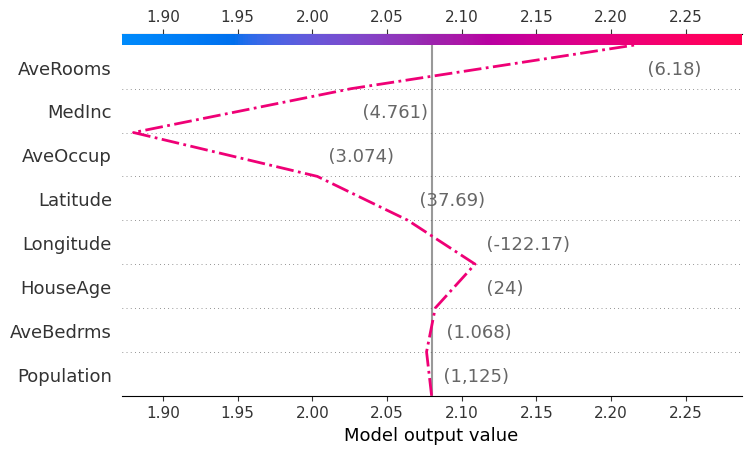

In [10]:
shap.decision_plot(
    explainer.expected_value, 
    shap_values.values[observation_of_interest], 
    shap_values.data.iloc[observation_of_interest], # we use the nonstandardized feature values here to display the original values in the plot
    highlight=0)

It's probably the easiest to read this plot from the bottom to the top. At the bottom, the dashed line starts at the average prediction for the whole data set. Then, as we move up the plot row by row, we're looking at each feature's effect on the prediction for our single observation, given the current set of feature values. If the line moves a lot to the left or right, then the feature for that row changes the prediction by a lot.

As we move from the bottom to the top of the plot, we notice that *Population*, *AveBedRooms*, and *HouseAge* have only a small impact on the prediction, whereas *AveRooms*, *AveOccup* and *MedInc* have larger effects. The values in parentheses in each row show the value for each feature for the houses in this census block. So, we can see that houses in this block are 24 years old on average and have an average occupancy of 3.07. As we move further up the plot, we notice that the census block's *AveOccup* decreases the predicted median price, according to our model, while the *AveRooms* value strongly increases the median price of the houses.

When we sum up all the SHAP-calculated effects of the features, we see that the model predicts that the median house price in this census block is about 2.21. This can be read off the plot directly: it's where the dashed line ends up at the top of the plot. The value for this sample is above 2.08 (from which the decision plot started at the bottom), the average predicted median price for all houses in all the census blocks in the data set we used to compute the shapley values.

*Note: The Shapley value can be misinterpreted. The Shapley value of a feature value is not the difference of the predicted value after removing the feature from the model training. The interpretation of the Shapley value is: Given the current set of feature values, the contribution of a feature value to the difference between the actual prediction and the mean prediction is the estimated Shapley value.*

#### Force Plot

The force plot visualizes the same information as the abovementioned decision plot. The force plot compresses the information we saw in the decision plot vertically. The effects of all the features now appear on a single row, instead of each feature appearing on its own row. This visualization is more compact, but we can still see the same information that we saw in the decision plot. This plot is useful when the number of features is not too high. For an application example on medical data see [Lundberg et al. 2018](https://rdcu.be/baVbR)

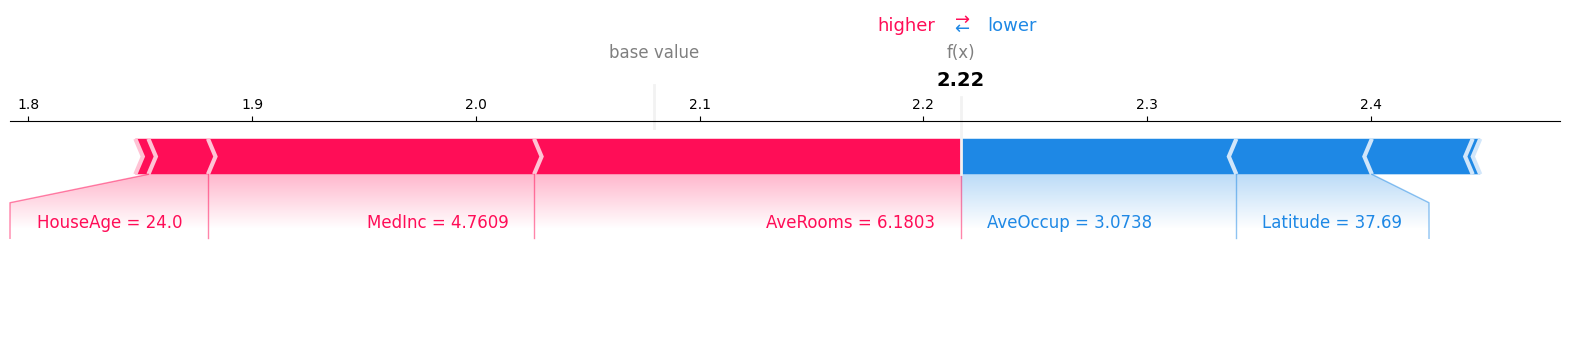

In [11]:
shap.force_plot(
    explainer.expected_value, 
    shap_values.values[observation_of_interest], 
    shap_values.data.iloc[observation_of_interest], 
    matplotlib=True)

The average prediction for all houses in all the census blocks is labeled as the *base value* here, which is about 2.08. The predicted median house price in this census block is 2.21, labeled as the *f(x)*.

Features that increase the predicted price from the *base value* are colored in red and are distinguished from each other by arrows pointing to the right. Features that decrease the predicted price are colored in blue with left-pointing arrows. Features with larger effects on the prediction, occupy more space in the row of arrows. The two sets of features point to the *output value*. The features' names and values are printed below the row of arrows.

You can find more advanced use cases for decision and force plots [here](https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/decision_plot.html).

#### Waterfall Plot

Another option to display the explanations for individual predictions is waterfall plots. Waterfall plots summarise the same information as the decision and force plot, but plot the contribution of each feature in numbers.

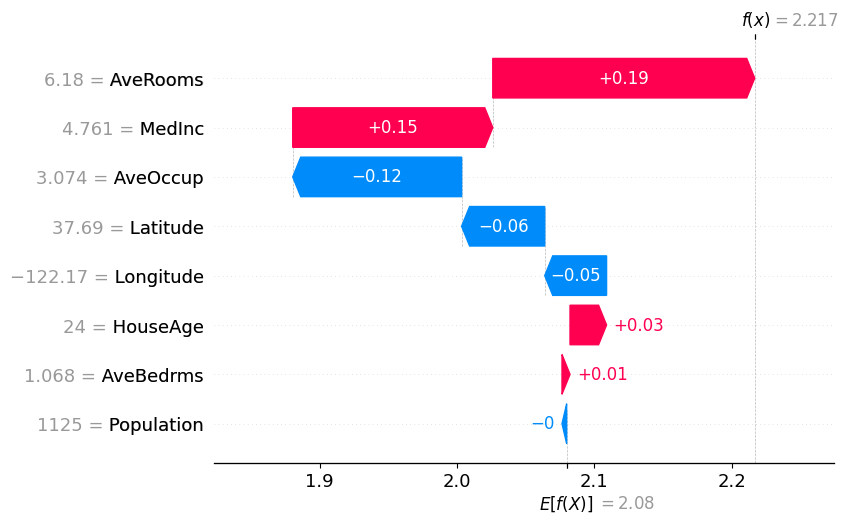

In [12]:
# get base_value as int (not list of int)
sv = shap_values[observation_of_interest]
shap.plots.waterfall(sv)

The bottom of the waterfall plot starts with the expected value of the model output, and then each row shows how the positive (red) or negative (blue) contribution of each feature moves the value from the expected model output to the model output for this prediction. The gray text before the feature names shows the value of each feature for this sample.

### Global Explanations with SHAP

#### Global Bar Plots

The local explanation plots are great for looking at the model's predictions with granularity. But what if we want a simple summary of how important each feature is in making predictions for the entire data set - something like *feature importance*?

The SHAP package covers this case by providing a global feature importance plot, where the global importance of each feature is taken to be the mean absolute value for that feature over all the given samples.

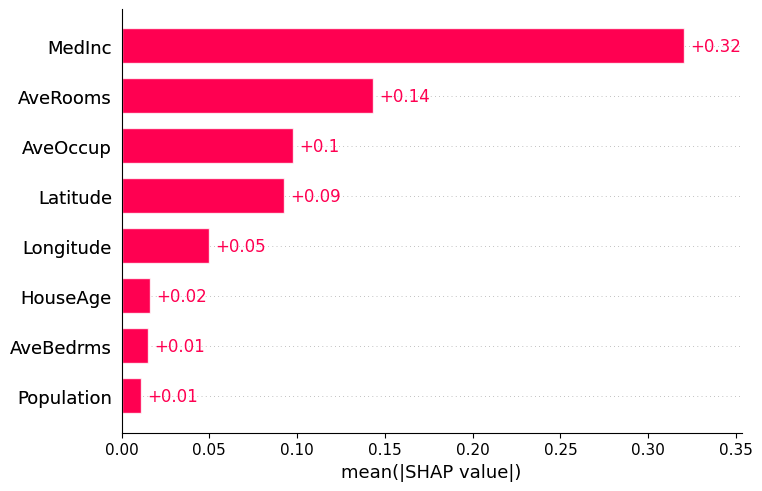

In [13]:
shap.plots.bar(shap_values)

The number beside each feature indicates the average absolute SHAP value. Those feature importances are calculated by taking the absolute values of all the Shapley values and averaging them for each feature. Look closely, and you can see that the calculation below matches the numbers in the global bar plot above.

In [14]:
pd.Series(np.abs(shap_values.values).mean(axis=0), index=shap_values.data.columns).sort_values(ascending=False)

MedInc        0.320402
AveRooms      0.143007
AveOccup      0.097563
Latitude      0.092527
Longitude     0.049725
HouseAge      0.016136
AveBedrms     0.014913
Population    0.011025
dtype: float64

Just to make sure we understand what's happening here. Remember, each row is an observation representing a census block of houses, and we have 800 census blocks. Each column is a feature, and there are eight features. All we did in the calculation above was to average all the (absolute values of the) 800 Shapley values in each column. That gave us eight sums, one for each feature, and those are our eight feature importances for this model. It's that simple.

Let's pause and consider this for a moment because this is a really important point: the feature importance for the entire model is calculated directly from their importance for individual observations. In other words, the importance is consistent between the model's global and local behavior. This consistency is a remarkable and really important characteristic that many model interpretability methods do not offer.

The SHAP package also provides local bar plots, bar plots separated by cohorts or ordered by feature clustering. For more information on the different bar plots see [here](https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/bar.html).

#### Beeswarm and Violin Plots

The SHAP package also provides a more granular look at feature importances for the entire data set.

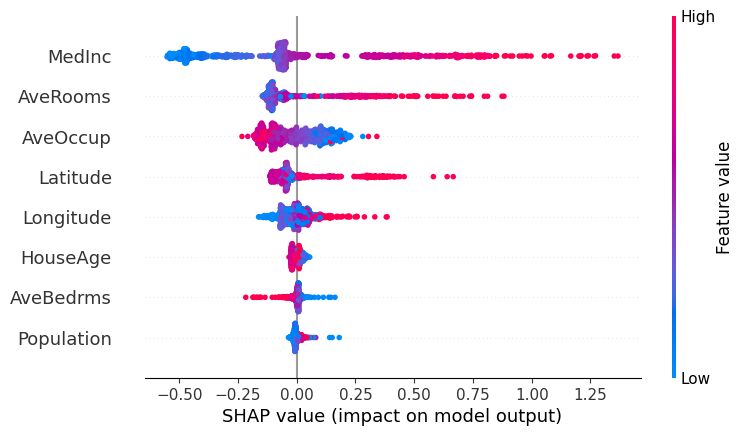

In [15]:
shap.plots.beeswarm(shap_values)

The beeswarm plot is designed to display an information-dense summary of how the top features in a dataset impact the model’s output. Here, the Shapley values of every observation are plotted for each feature. Additionally, the coloring indicates whether low (or high) values of each feature increase (or decrease) the model's predictions.

For example, we can see that high median incomes (*MedInc*) increase the predictions of house prices (i.e., the Shapley values are greater than zero) while low median incomes decrease those predictions (i.e., the Shapley values are < 0). Also, the effects of *MedInc* on the model's predictions exhibit a positively skewed distribution: most values of *MedInc* decrease the model's predictions, while a long tail of high *MedInc* values increase the model's predictions. With *AveOccup*, there is a similar effect in the opposite direction. Low values of average occupancy increase the model's predictions.

The violin summary plot, on the other hand, offers a compact representation of the distribution and variability of SHAP values for each feature. Individual violin plots are stacked by the importance of the particular feature on model output (sum of the absolute values of the SHAP values per feature). The violins can therefore provide insights into the range, variability, skewness, symmetry, and multimodality of the SHAP value distribution for a specific feature.

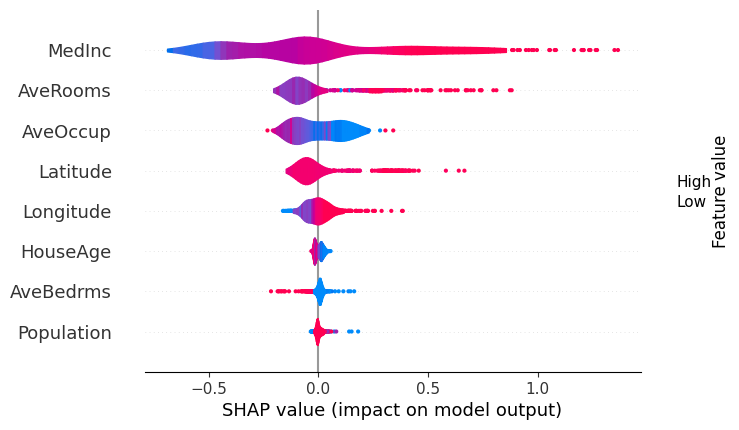

In [16]:
shap_values.expected_value = explainer.expected_value
shap.plots.violin(shap_values)

#### Heatmap Plots

The heatmap plot shows the distribution of SHAP values, sorted by the explanation similarity of the samples. The instances are plotted on the x-axis, while the model features are plotted on the y-axis, and the SHAP values are encoded on a color scale. By default, the samples are ordered based on a hierarchical clustering by their explanation similarity. This results in samples that have the same model output for the same reason getting grouped together. The plot above the heatmap shows the model's prediction for each instance and the grey dashed line is the average model's prediction for the whole dataset.

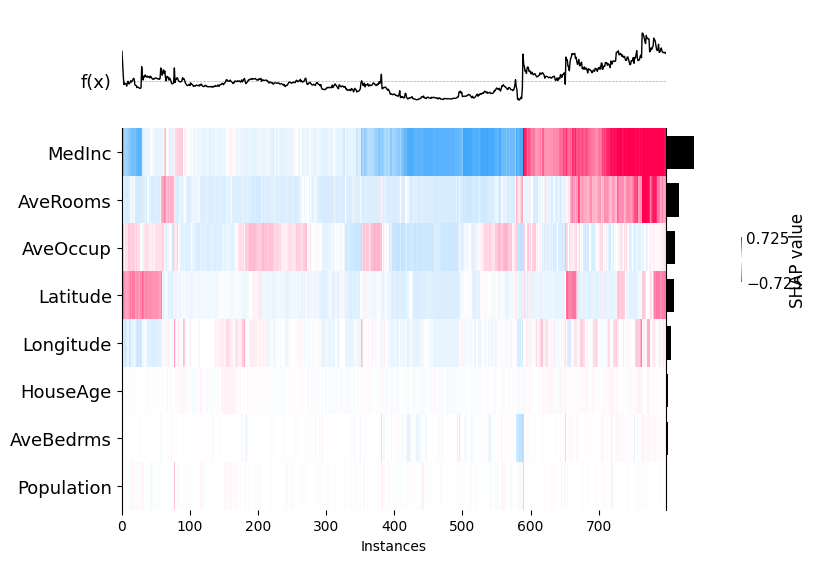

In [17]:
shap.plots.heatmap(shap_values)

The plot above shows the most significant separation for the *MedInc* and *AveRooms* features. We can see that instances with predictions below the average prediction for the whole dataset (grey dashed line) tend to have negative SHAP values for *MedInc*, while instances with predictions above the average prediction for the whole dataset tend to have high SHAP values for *MedInc* and *AveRooms*. 

--------

## Extra Material: SHAP for Multi-Class Classification

### The Wine dataset: Data and Model Loading

Let's use the wine quality dataset to see how SHAP can be used to explain multi-class classification models. The **Wine Recognition dataset** contains 178 wine samples from three different cultivators of wine in the same region in Italy. The wine was chemically analyzed and 13 different chemical attributes like *alcohol*, *malic acid*, *flavanoids* etc were measured. Our goal is to **classify wines** and find the most predictive features.

<center><img src="https://github.com/HelmholtzAI-Consultants-Munich/XAI-Tutorials/blob/main/docs/source/_figures/dataset_red_wine.jpg?raw=true" width="900" /></center>

<font size=1> Source:
[Link](https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009)

In the notebook [*0-Tutorial_RandomForest_Model_Housing_Wine_Penguins.ipynb*](./0-Tutorial_RandomForest_Model_Housing_Wine_Penguins.ipynb), we explain how to do the exploratory data analysis, preprocess the data and train a Random Forest model with the given data. The focus of this notebook lies on the interpretation of the previously trained model.

In [18]:
# Load and unpack the data
with open('../models/model_rf_wine.pickle', 'rb') as handle:
    data_and_model = pickle.load(handle)
    
X_train = data_and_model[0]
X_test = data_and_model[1]
y_train = data_and_model[2]
y_test = data_and_model[3]
model_wine = data_and_model[4]

X_train.head()

# is the model performing reasonably on the training data?
print(f'Model Performance on training data: {round(model_wine.score(X_train, y_train)*100,2)} % accuracy.')

# is the model performing reasonably on the test data?
print(f'Model Performance on test data: {round(model_wine.score(X_test, y_test)*100,2)} % accuracy.')

Model Performance on training data: 100.0 % accuracy.
Model Performance on test data: 97.22 % accuracy.


As we can see by the numbers above, our model performs perfectly on the training set and also generalizes great to the independent test set.

*Note: you should keep in mind that interpreting a low-performing model can lead to wrong conclusions.*

### SHAP Analysis

When using SHAP to explain a classifiers output, the default vaöue in TreeExplainer for `model_output="raw"`, which explains the raw output of the model. For regression models, "raw" is the standard output. For classification this is the log odds ratio. We can set the `model_output="probability"` explaining the output of the model transformed into probability space, i.e. SHAP values now sum to the probability output of the model. One major difference when analysing multi-class classification models with SHAP, compared to binary classification or regression models, is that we will get one shapley value matrix and expected value per class. Hence, in our case we will get three SHAP value matrices and expected values because we have three classes of wines. 

*Note: the order of the SHAP value matrices and expected value output is the same as the sorting of the target classes.*

In [19]:
# run SHAP
explainer = shap.TreeExplainer(model=model_wine, data=shap.maskers.Independent(X_train, max_samples=len(X_train)), model_output="probability")
shap_values = explainer(X_train)

In [20]:
# get original unscaled feature values
scaler = data_and_model[5]
X_train_unscaled = scaler.inverse_transform(X_train)
shap_values.data = pd.DataFrame(scaler.inverse_transform(X_train), columns = X_train.columns).round(4)

#NOTE: the new SHAP package is still a bit buggy.
#      the returned dimensions for the shaply value
#      matrix are swapped. Hence, we need to put
#      then into correct order first.
shap_values.values = list(np.transpose(shap_values.values,(2,0,1)))

For our multiclass classification task, shap explainer produces three expected values, corresponding to the average probability for each class, which is essentially the class frequency in the dataset.

In [21]:
# average prediction for the dataset
ev = explainer.expected_value
pm = np.mean(model_wine.predict_proba(X_train), axis=0)

print(f'Models average prediction for our data set is for class 0: {round(pm[0],3)}, for class 1: {round(pm[1],3)}, for class 2: {round(pm[2],3)}')
print(f'Expected value for our data set is for class 0: {round(ev[0],3)}, for class 1: {round(ev[1],3)}, for class 2: {round(ev[2],3)}')

Models average prediction for our data set is for class 0: 0.32, for class 1: 0.405, for class 2: 0.274
Expected value for our data set is for class 0: 0.32, for class 1: 0.405, for class 2: 0.274


### Local Explanations

Since we have three shapley value matrices, we will have to visualize the local explanations separately for each class.

In [22]:
observation_of_interest = 5
print(f'Class for observation of interest: {y_train[observation_of_interest]}; and models prediction for the observation of interest: {model_wine.predict(X_train)[observation_of_interest]}')

Class for observation of interest: type_2; and models prediction for the observation of interest: type_2


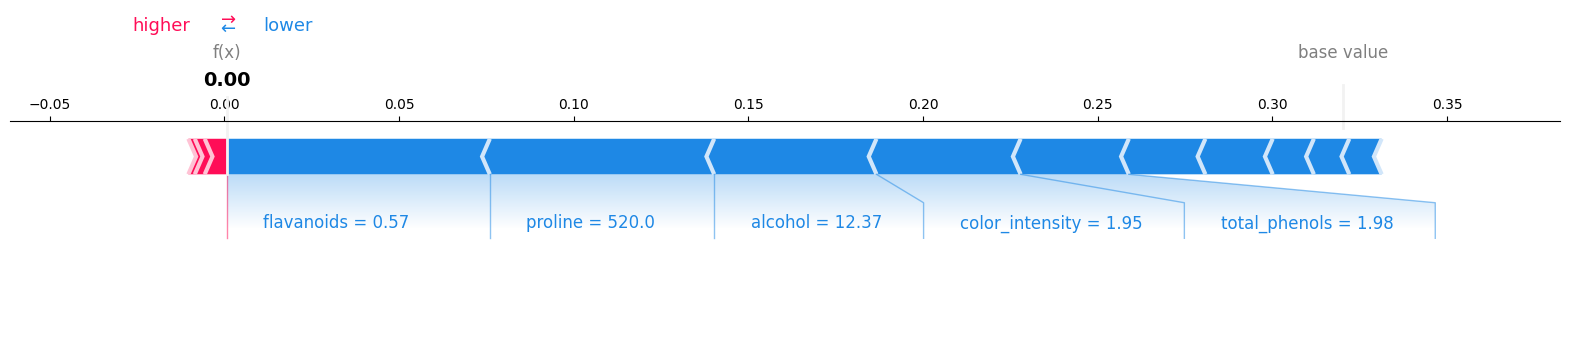

In [23]:
# force plot for class 0
target_class = 0
shap.force_plot(
    explainer.expected_value[target_class], 
    shap_values.values[target_class][observation_of_interest], 
    shap_values.data.iloc[observation_of_interest], 
    matplotlib=True)

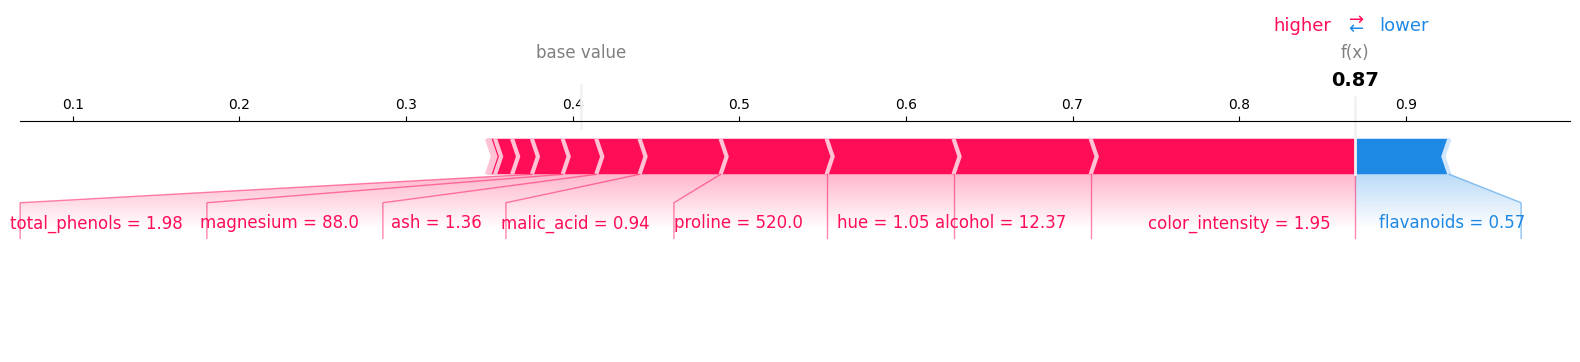

In [24]:
# force plot for class 1
target_class = 1
shap.force_plot(
    explainer.expected_value[target_class], 
    shap_values.values[target_class][observation_of_interest], 
    shap_values.data.iloc[observation_of_interest], 
    matplotlib=True)

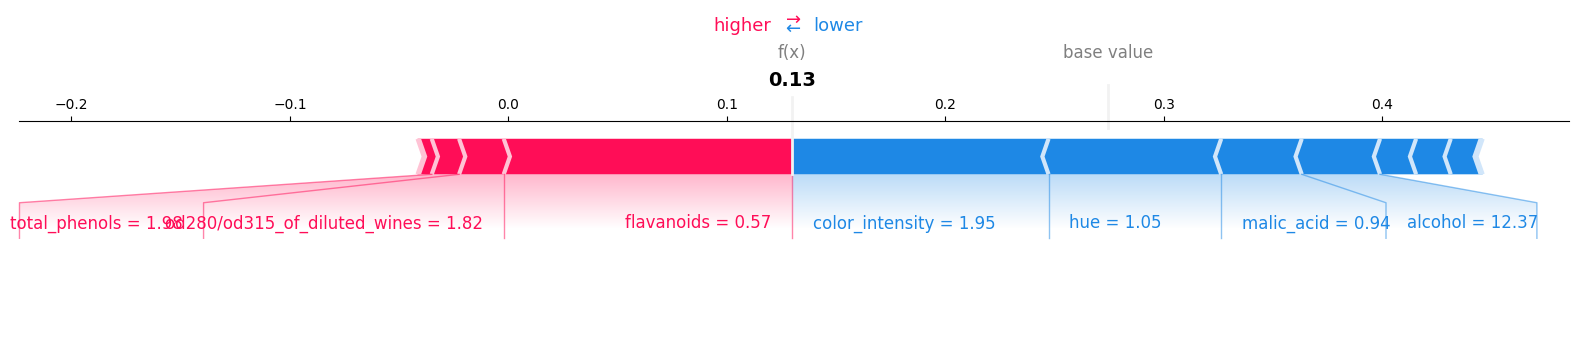

In [25]:
# force plot for class 2
target_class = 2
shap.force_plot(
    explainer.expected_value[target_class], 
    shap_values.values[target_class][observation_of_interest], 
    shap_values.data.iloc[observation_of_interest], 
    matplotlib=True)

The average probability for each class is labeled as the *base value* in the respective plots (0.32 for type 1, 0.405, for type 2 and 0.27 for type 3). The predicted wine class probability for the observation of interest is labeled as the *f(x)*.

Comparing the three plots above, we can see that our observation of interest has a high probability of belonging to type 2 (probability = 0.87), while it has a low probability of belong to type 1 (probability = 0) or type 3 (probability = 0.13). 

Furthermore, we can see which feature contribute to a low or high class probability:
- type 1: the proline and flavanoids values highly lower the probability for this class
- type 2: the color intensity value highly increases the probability for this class
- type 3: the color intensity and hue value highly lowers the probability for this class

### Global Explanations

For the global explanations, we can visualize a combined bar plot that shows the average absolute SHAP values stacked per class.

*Note: the shap.plots.bar() function of the new package does currently not work for multi-class classification problems. Instead, we have to use the old shap.summary_plot() function.*

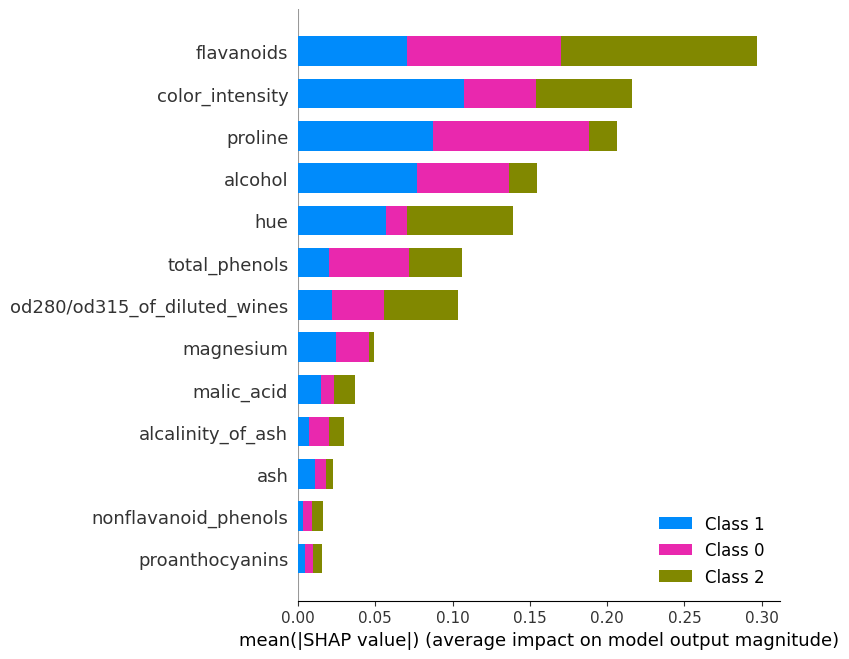

In [26]:
shap.summary_plot(
    shap_values.values, 
    shap_values.data, 
    plot_type='bar')

When we want to visualize the SHAP value summary as a beeswarm or violin plot, we have to do the visualization class-wise again.

*Note: the shap.plots.beeswarm() function of the new package does currently not work for multi-class classification problems. Instead, we have to use the old shap.summary_plot() function. For the violin plot, we have to manually select the dimension of interest.*

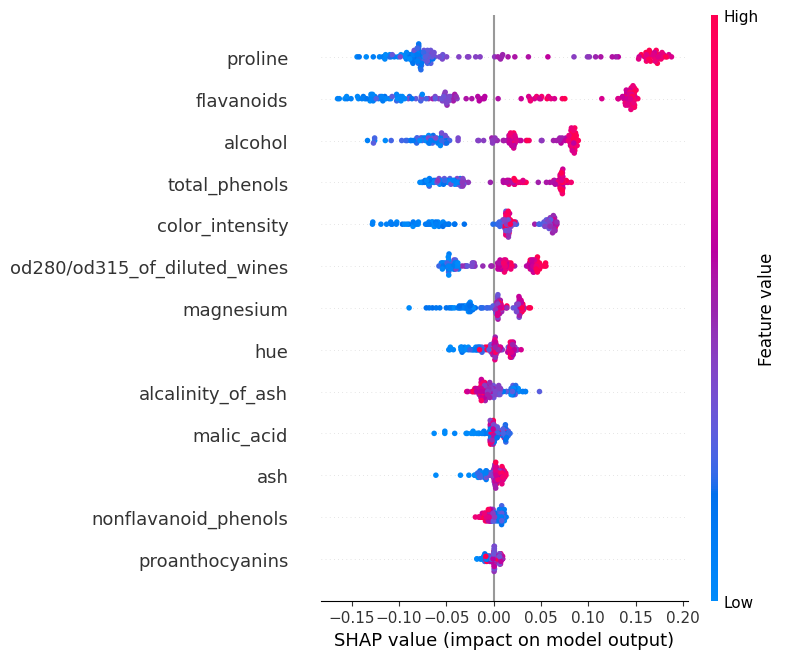

In [27]:
# summary plot for class 0
target_class = 0
shap.summary_plot(
    shap_values.values[target_class], 
    shap_values.data)

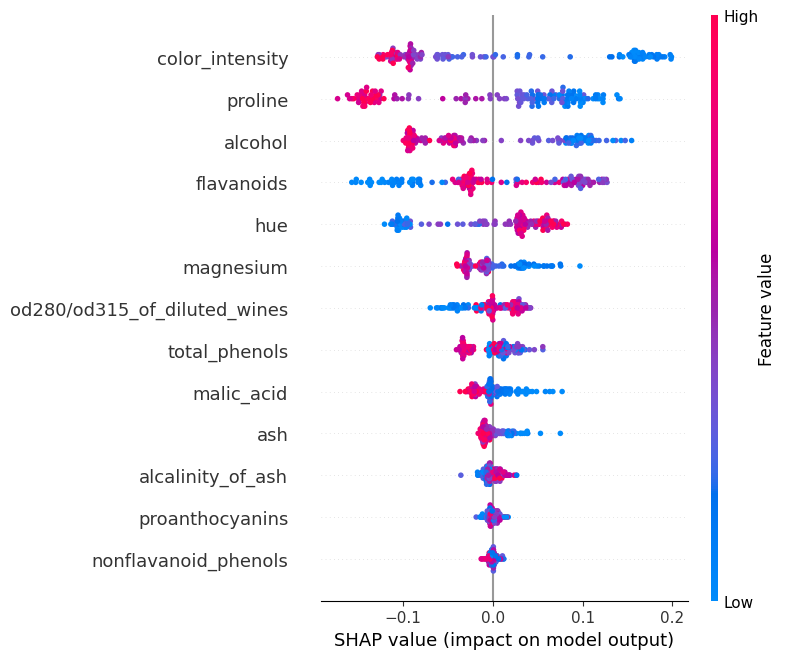

In [28]:
# summary plot for class 1
target_class = 1
shap.summary_plot(
    shap_values.values[target_class], 
    shap_values.data)

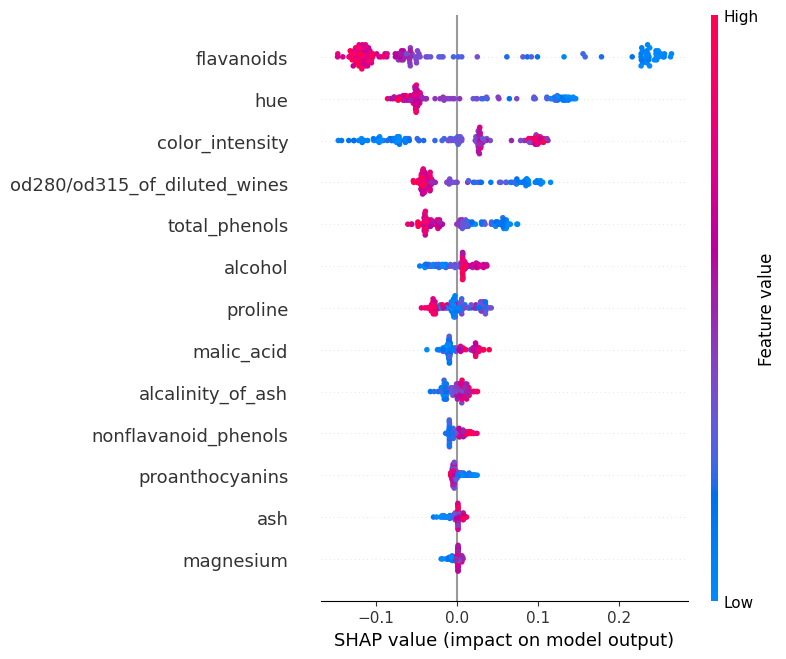

In [29]:
# summary plot for class 2
target_class = 2
shap.summary_plot(
    shap_values.values[target_class], 
    shap_values.data)

From the plots above, we can see for instance that:

- high proline, flavanoids and alcohol values increase the probability for type 1 wines
- low color intensity, proline and alcohol values increases the probability for type 2 wines
- low flavanoids and hue but high color intensity values increase the probability for type 3 wines